<a href="https://colab.research.google.com/github/SrTorGonz/Project-1---Deep-Learning/blob/main/Project_1_Daniel_Torres_Juan_Plata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autores:** Daniel Alejandro Torres González & Juan David Plata Garrido


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [2]:
# Carga de librerías
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

from sklearn.model_selection import train_test_split
# Carga de módulos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


Cargar imágenes, para esto se deben subir a colab los archivos .npz colocados en GitHub

In [3]:
# Cargar imágenes y etiquetas
train_images = np.load('k49-train-imgs.npz')['arr_0']
train_labels = np.load('k49-train-labels.npz')['arr_0']
test_images = np.load('k49-test-imgs.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']

print("Tamaño de datos de entrenamiento:", train_images.shape)
print("Tamaño de datos de prueba:", test_images.shape)

Tamaño de datos de entrenamiento: (232365, 28, 28)
Tamaño de datos de prueba: (38547, 28, 28)


Normalizar imágenes y redimensionar para indicar que las imagenes estan en escala de grises

In [4]:
# Normalizar imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0

# Añadir canal de color (grayscale -> (28, 28, 1))
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Verificar dimensiones
print("Dimensiones finales de entrenamiento:", train_images.shape)

Dimensiones finales de entrenamiento: (232365, 28, 28, 1)


Se aleatorizan los datos y se crean los arreglos de validacion con la misma cantidad de datos de test, el random state 42 asegura que se va a obtener la misma aleatorizacion en caso de volver a correr el codigo

In [5]:
# Aleatorización y separación de conjunto de validación
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=38547, random_state=42, shuffle=True
)

# Verificar tamaños finales
print("Tamaño de datos de entrenamiento después de la división:", train_images.shape)
print("Tamaño de datos de validación:", val_images.shape)

Tamaño de datos de entrenamiento después de la división: (193818, 28, 28, 1)
Tamaño de datos de validación: (38547, 28, 28, 1)


Convertir los labels a categorical

In [6]:
# Convertir etiquetas a One-Hot Encoding
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

# Verificar la forma de las etiquetas después de la conversión
print("Dimensión de train_labels (One-Hot):", train_labels.shape)
print("Dimensión de val_labels (One-Hot):", val_labels.shape)
print("Dimensión de test_labels (One-Hot):", test_labels.shape)

Dimensión de train_labels (One-Hot): (193818, 49)
Dimensión de val_labels (One-Hot): (38547, 49)
Dimensión de test_labels (One-Hot): (38547, 49)


In [41]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid','softmax']),
            kernel_initializer=hp.Choice('initializer', ['he_uniform', 'glorot_uniform','glorot_normal']),
        ))

        # Añadir Dropout después de cada capa oculta
        model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.3, step=0.1)))  # Dropout entre 20% y 30%

    # Capa de salida
    model.add(Dense(49, activation='softmax'))

    # Compilar el modelo
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Añadir EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='kuzushiji_dense_tuning'
)

# Ejecutar la búsqueda
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), callbacks=[early_stop])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Mostrar los mejores parámetros encontrados
print(f"""
Mejores hiperparámetros encontrados:
- Número de capas ocultas: {best_hps.get('num_layers')}
- Neuronas por capa: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Activación: {best_hps.get('activation')}
- Inicializador: {best_hps.get('initializer')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Construir el mejor modelo encontrado
best_model = tuner.hypermodel.build(best_hps)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True
)

history = best_model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=64,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop]
)


Reloading Tuner from my_dir/kuzushiji_dense_tuning/tuner0.json

Mejores hiperparámetros encontrados:
- Número de capas ocultas: 2
- Neuronas por capa: [512, 448]
- Activación: relu
- Inicializador: glorot_normal
- Learning rate: 0.00016960331830446725

Epoch 1/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5538 - loss: 1.8106 - val_accuracy: 0.8071 - val_loss: 0.7434
Epoch 2/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7942 - loss: 0.7730 - val_accuracy: 0.8556 - val_loss: 0.5386
Epoch 3/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8407 - loss: 0.5881 - val_accuracy: 0.8806 - val_loss: 0.4432
Epoch 4/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8660 - loss: 0.4908 - val_accuracy: 0.8927 - val_loss: 0.3947
Epoch 5/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8815 - loss: 0.4253 - val_accuracy: 0.9013 - val_loss: 0.3622
Epoch 6/20
3029/3029 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8947 - loss: 0.3800 - val

In [42]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f'\nPrecisión en el conjunto de prueba: {test_acc * 100:.2f}%')

1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8829 - loss: 0.4713

Precisión en el conjunto de prueba: 88.20%


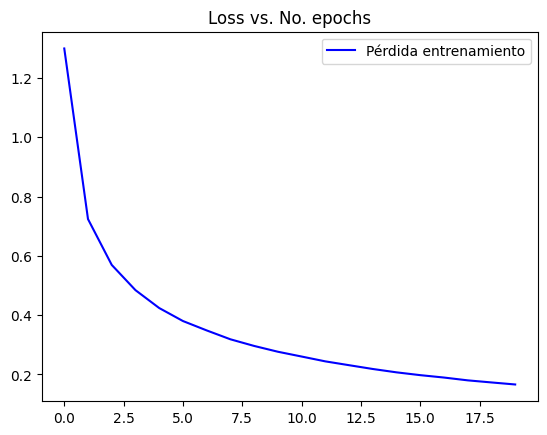

In [43]:
# Gráfica de Loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.title('Loss vs. No. epochs')
plt.legend()
plt.show()